# Explainable AI con algoritmi genetici

Si mette il focus su problemi di classificazione o, per essere più precisi,
sui classificatori stessi.

Non è infatti di nostro interesse se la classificazione sia corretta o meno,
ci interessa sapere:

- "Perché" i dati sono stati classificati in quel modo.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

Prendiamo come riferimento un problema semplice come quello dato dal dataset
Iris, il quale, a fini di rappresentazione verrà ulteriormente semplificato
a 2 sole feature (lunghezza e larghezza del petalo). Abbiamo poi 3 possibili
classi.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il plot del dataset.


<Figure size 640x480 with 0 Axes>

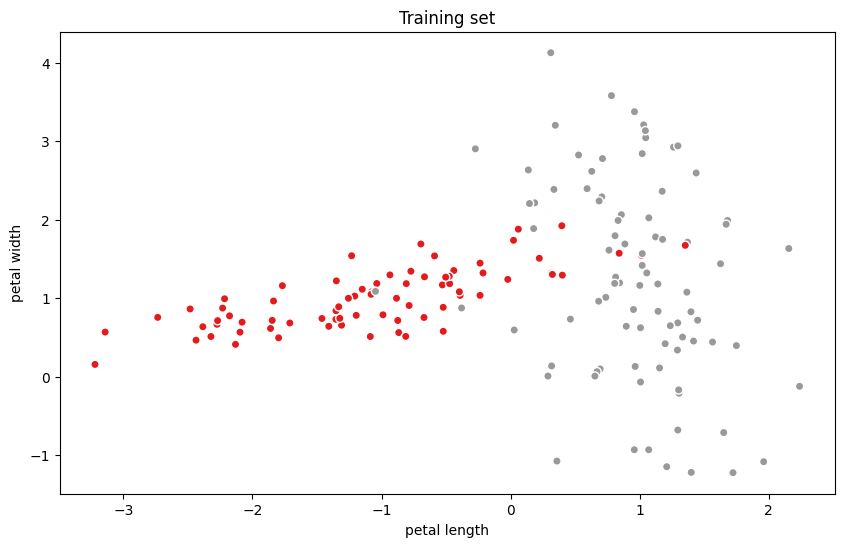

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# only for plotting
train_coords = X_train.T

plt.set_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.scatter(train_coords[0], train_coords[1], c=y_train, ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente.

In realtà a noi non interessa per il momento testare la correttezza del modello
ma solo usare dati non presenti in fase di training per ciò che andremo a fare
dopo.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno il dataset di riferimento.


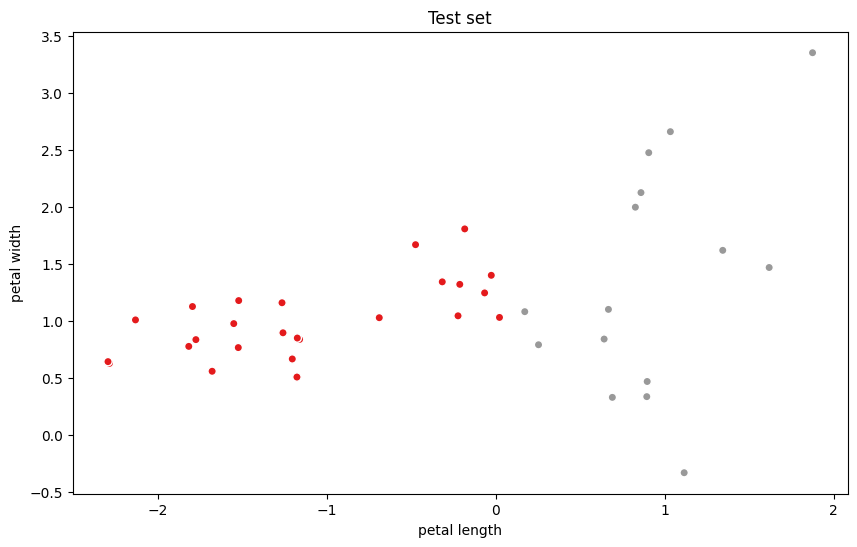

In [3]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

test_coords = X_test.T

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
evidenziato in verde


point class: 1


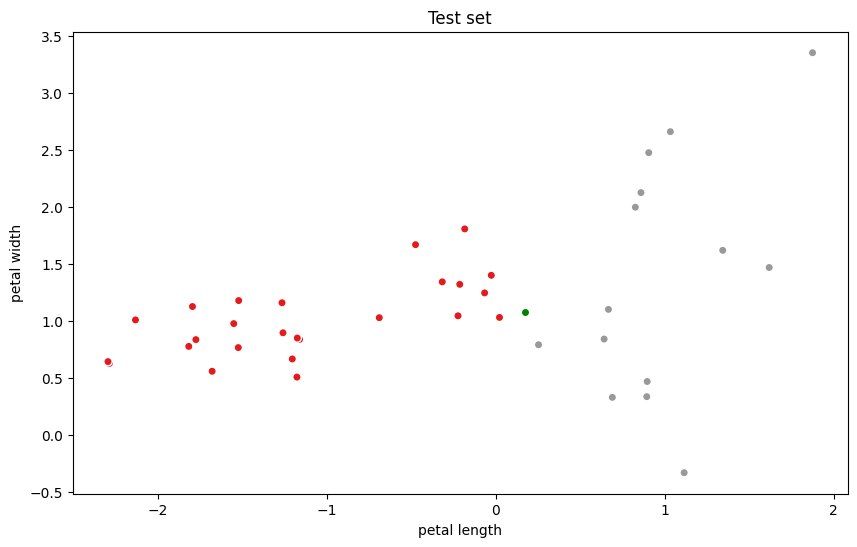

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")

point = X_test[7]
point_class = y_predicted[7]
print(f"point class: {point_class}")

plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

e proseguiamo con la fase di explaining tramite un algoritmo genetico.

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 3).

Andremo a definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché quel punto è stato classificato in un determinato modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

### Struttura del cromosoma

La struttura del cromosoma è semplicemente formata dal vettore delle feature
dei vari individui.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
verosimile con il dataset che stiamo considerando.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

Per generare punti sintetici intorno a quello di riferimento usiamo due
possibili distribuzioni

- **Uniforme**: nella generazione di punti tramite distribuzione uniforme si
  ottiene una popolazione sintetica equamente distribuita entro un "raggio" che
  corrisponde ad una frazione $\alpha$ della deviazione standard di entrambe le
  feature. Avremo quindi uno spazio di valori per le feature sintetiche di
  questo tipo:
  $$[-\sigma_i \cdot \alpha, \; \sigma_i \cdot \alpha]$$
  dove $\sigma_i$ è la deviazione standard dell'$i$-esima feature rispetto
  a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a scalare
con la stessa dispersione che ha popolazione intera, mantenendo le
caratteristiche delle distribuzione di punti iniziale.

Una distribuzione uniforme invece riempe uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento.


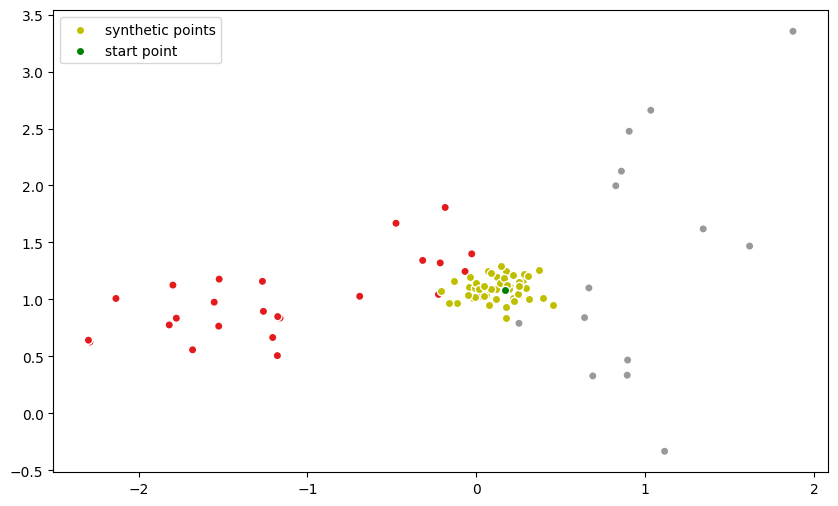

In [6]:
from numpy import random
from ppga import base


def generate_normal(point, sigma, alpha: float) -> np.ndarray:
    return random.normal(point, alpha * sigma, size=(2,))


def generate_uniform(point, sigma, alpha: float) -> np.ndarray:
    return random.uniform(point - sigma * alpha, point + sigma * alpha, size=(2,))


toolbox = base.ToolBox()
toolbox.set_generation(generate_normal, point=point, sigma=sigma, alpha=0.15)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come possiamo vedere gli individui sintetici generati si dispongono intorno
al punto di partenza considerato con maggiore densità vicino ad esso.

### Funzione di valutazione

L'altro parametro fondamentale è la funzione di valutazione del valore di
fitness di ciascun individuo sintetico. Nello specifico andiamo a definire
due funzioni di valutazione differenti.

- La prima funzione ci serve nel caso in cui si voglia rimanere nella stessa
  classe del punto di riferimento. Questa funzione dovrebbe premiare i punti
  vicini al punto di partenza ma classificati diversamente. Al contrario
  dovrebbe penalizzare punti simili al punto di partenza e classificati in
  allo stesso modo.
- L'altra funzione di valutazione dovrebbe invece valutare meglio individui
  classificati in una classe target di nostro interesse ma che rimangono
  vicini al punto di partenza. L'obbiettivo qui è andare a definire il
  confine tra le due classi.

Il valore di fitness in sé viene invece dato dalla distanza euclidea tra i
due punti. Tale distanza viene trattata e manipolata diversamente a seconda
di quale caso stiamo trattando e alla classificazione del punto sintetico.

Con la prima funzione di fitness andremo a creare una sorta di effetto
repulsivo dal punto di partenza fin tanto che il punto viene valutato nello
stesso modo del punto originale. Una volta che il punto sintetico cambia classe
viene riportato dentro il boundary di classificazione originale. In questo modo
si va a costruire una sorta di confine tra la classe di partenza e tutte le
altre classi.

Con la seconda funzione cerchiamo invece di far migrare i punti sintetici verso
una classe specifica, andando quindi a definire solo il boundary tra la classe
di partenza e la classe di arrivo.

#### Stessa classe

Vogliamo quindi allontanare i punti fin tanto che sono classificati nella
stessa classe del punto originale per poi riavvicinarli una volta cambiata la
classe per riportarli dentro al confine.

Vogliamo quindi una funzione di fitness che valuta peggio i punti classificati
allo stesso modo del punto di riferimento e vicini ad esso. Al contrario i
punti classificati in una qualsiasi altra classe vengono premiati con un valore
di fitness tanto più alto quanto più piccola è la distanza con il punto
d'origine.

$$
f(x_i) = \begin{cases}
    1 - d(x_0, x_i) & \text{se } C_0 = C_i \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $x_0$ e $C_0$ sono rispettivamente il vettore delle feature e la classe del
punto iniziale, mentre $x_i$ e $C_i$ sono rispettivamente le feature e la classe
dell'$i$-esimo punto sintetico.


In [7]:
from numpy import linalg


def same_evaluate(chromosome, point, classifier):
    # classification
    pt_class = classifier.predict(point.reshape(1, -1))
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(point - chromosome, ord=2)
    same_class = 5.0 if pt_class == synth_class else 0.1

    return (same_class * distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(same_evaluate, point, classifier)
population = list(map(toolbox.evaluate, population))

Andiamo quindi a vedere come sono stati classificati i punti sintetici e
di modo da capire come si è comportata la funzione di valutazione.


1


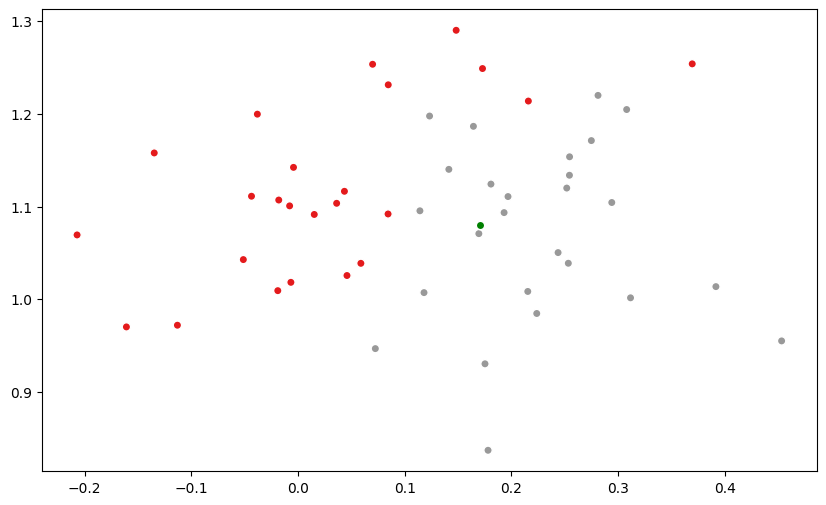

In [8]:
classes = [classifier.predict(i.chromosome.reshape(1, -1)) for i in population]
plt.figure(figsize=(10, 6))
plt.scatter(synth_points.T[0], synth_points.T[1], c=classes, ec="w")
plt.scatter(point[0], point[1], c="g", ec="w")
print(point_class)
plt.show()

Vediamo quindi come sono stati valutati in funzione della loro classificazione
e distanza dal punto d'origine.


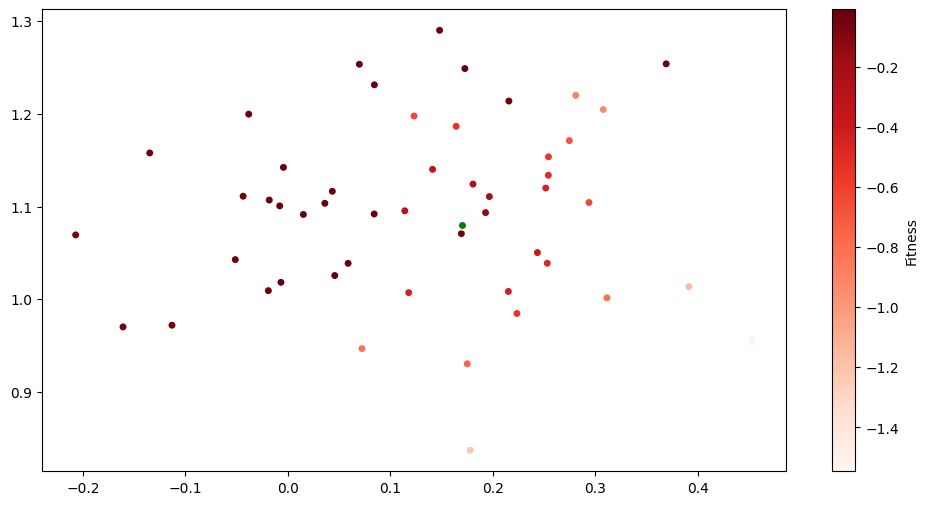

In [9]:
fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

#### Cambio di classe

Andiamo ora a costruire una funzione di fitness di modo da premiare gli
individui che riescono ad essere classificati in una classe target differente
da quella di partenza.

In questo caso abbiamo una funzione con un comportamento leggermente differente:

$$
f(x_i) = \begin{cases}
    1 - d(x_0, x_i) & \text{se } C_i \neq C_t \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $C_t$ è la classe target a cui stiamo cercando di arrivare.


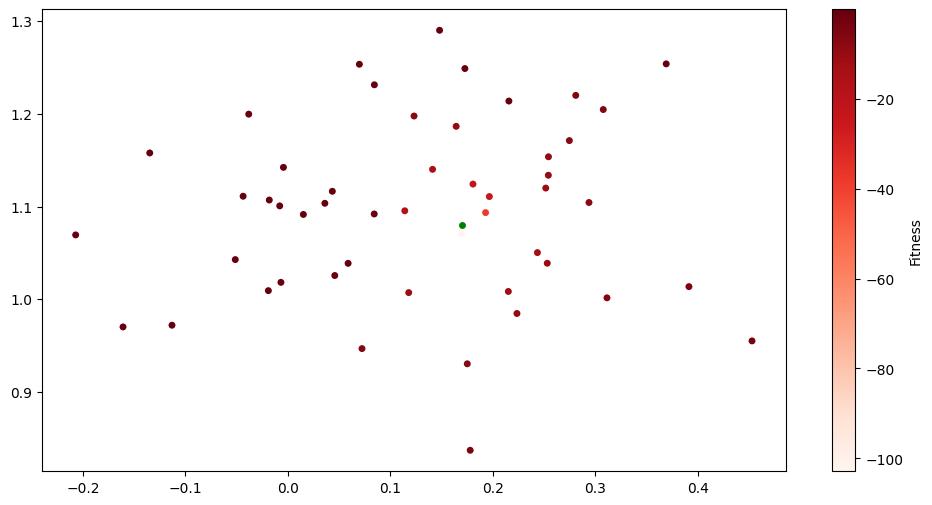

In [10]:
def other_evaluate(chromosome, point, classifier, target):
    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(point - chromosome, ord=2)

    if target == synth_class:
        return (distance,)
    else:
        return (1 / distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(other_evaluate, point, classifier, (point_class + 1) % 2)
population = list(map(toolbox.evaluate, population))

fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: questi due operatori andrebbero a mischiare
  le feature dei due individui lasciandole invariate, sarà poi compito
  dell'operatore di mutazione effettuare variazioni sui valori stessi.
- **Media e fattore stocastico**: in alternativa si potrebbero creare due figli
  le cui feature sono la media delle feature dei genitori. Dato che sarebbero
  due figli uguali si potrebbe aggiungere un termine casuale per differenziarli.
  In alternativa si potrebbe generare un solo figlio da ogni coppia.

Per i test andremo ad usare un semplice _one point crossover_.


In [11]:
def cx_one_point(father, mother):
    cx_point = random.randint(1, len(father))

    offspring1 = np.append(father[:cx_point], mother[cx_point:])
    offspring2 = np.append(mother[:cx_point], father[cx_point:])

    return offspring1, offspring2


toolbox.set_crossover(cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [0.25326989 1.03882097]
mother: [-0.11301182  0.97195212]
offspring 1: [0.25326989 0.97195212]
offspring 2: [-0.11301182  1.03882097]


Come possiamo vedere con due features andiamo semplicemente ad incrociare i
valori di padre e madre per generare due figli. Il problema di questo crossover
è che da solo non genera mai nuovi valori per le feature ma va ad esplorare
le possibili permutazioni dei valori già esistenti.

### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana
$$N(x_i, \; \alpha \cdot \sigma_i)$$
centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
una frazione ($\alpha$) della deviazione standard di quella feature calcolata
sull'intera popolazione ($\sigma_i$).


In [12]:
def mut_gaussian(individual, sigma, alpha: float = 0.05, indpb: float = 0.2):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i] * alpha)

    return individual


toolbox.set_mutation(mut_gaussian, sigma, 0.1, 0.8)
print(o1)
o1 = toolbox.mutate(o1)
print(o1)

[0.25326989 0.97195212]: 0.0
[0.31239681 1.0276354 ]: 0.0


L'operatore richiede quindi la deviazione standard di tutte le feature calcolata
sull'intera popolazione, un parametro $\alpha$ che regola l'intesità della
mutazione e la probabilità che ogni singola feature ha di essere mutata.


### Simulazione

Proviamo quindi ad effettuare una simulazione provando a capire quale sia il
modo migliore di far cambiare classe al punto in questione.

Di seguito è possibile vedere la i migliori individui della popolazione
sintetica finale, tutti raccolti nella _Hall of Fame_ generazione dopo
generazione.


generations: 100%|██████████████████████████████| 50/50 [00:12<00:00,  3.91it/s]


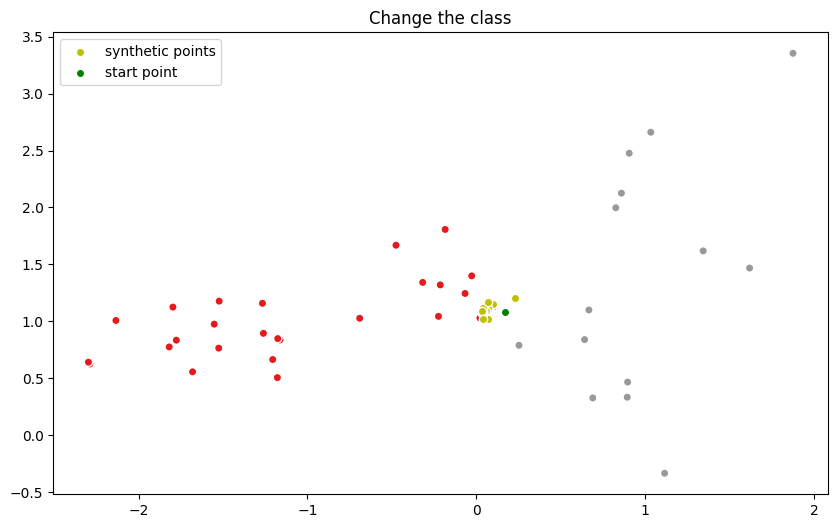

In [13]:
from ppga import tools, algorithms

toolbox.set_selection(tools.sel_ranking)
toolbox.set_replacement(tools.merge)

hof = base.HallOfFame(50)
population, stats = algorithms.psga(toolbox, 50, 0.8, 0.2, 50, hof)

synth_points = np.array([i.chromosome for i in hof])

plt.figure(figsize=(10, 6))
plt.title("Change the class")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come si può vedere, i punti sintetici si schiacciano sul confine tra una classe
e l'altra.

### Analisi

Il prossimo passo è quello di andare a comparare le feature del punto originale
con quelle dei punti sintetici che sono riusciti a cambiare classe. In questo
modo è possibile _spiegare_ come far cambiare classe ad un determinato punto.


In [14]:
hof = list(
    filter(
        lambda x: classifier.predict(x.chromosome.reshape(1, -1)) != point_class,
        hof.hof,
    )
)
print(f"best synth points: {len(hof)}")
for i in hof:
    print(f"{i} | class: {classifier.predict(i.chromosome.reshape(1, -1))}")

d1 = linalg.norm(hof[-1].chromosome[0] - point[0])
d2 = linalg.norm(hof[-1].chromosome[1] - point[1])

best synth points: 50
[0.10269281 1.08076993]: -0.06778239724651713 | class: [0]
[0.10269281 1.08111118]: -0.06778494165160096 | class: [0]
[0.10269281 1.08232756]: -0.06780798222964572 | class: [0]
[0.10269281 1.07785399]: -0.06783069932310948 | class: [0]
[0.10269281 1.08354393]: -0.06785282388629653 | class: [0]
[0.10269281 1.074274  ]: -0.0680610114050844 | class: [0]
[0.0999034  1.08354393]: -0.0706394140824328 | class: [0]
[0.0999034  1.07706997]: -0.07065116385194506 | class: [0]
[0.0999034 1.074274 ]: -0.07083941266023921 | class: [0]
[0.0999034  1.07377374]: -0.07088467433950044 | class: [0]
[0.0999034  1.07088733]: -0.071213928753189 | class: [0]
[0.0999034  1.06757464]: -0.07173322439378838 | class: [0]
[0.0999034  1.06111365]: -0.07316818531405211 | class: [0]
[0.09215294 1.07088733]: -0.07890126198034172 | class: [0]
[0.0999034  1.11618386]: -0.07910898595572866 | class: [0]
[0.09206932 1.09515493]: -0.07977484207366173 | class: [0]
[0.0999034 1.1199828]: -0.08089670998021

In [15]:
print(d1)
print(d2)

0.12872192304560287
0.05772541687869026
